# Load Data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import tensorflow_hub as hub

2023-08-30 11:28:10.642758: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 11:28:13.362131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 11:28:18.616252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 32
img_height = 200 
img_width = 200 

In [3]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'DownFER/train', # directory path
    validation_split = None, 
    subset = None, 
    image_size = (img_height, img_width), # image size of height and width
    batch_size = 32# batch size
)

Found 26880 files belonging to 6 classes.


2023-08-30 11:28:30.490056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 11:28:30.641911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 11:28:30.642332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'DownFER/test', # directory path
    validation_split = None, 
    subset = None, 
    image_size = (img_height, img_width), # image size of height and width
    batch_size = 32 # batch size
)


Found 7178 files belonging to 7 classes.


In [5]:
class_names = training_ds.class_names
print(class_names)
print(len(class_names))

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
6


In [6]:
# configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# cache() keeps images in memory to ensure dataset does not become a bottleneck 
  # while training the model
# prefetch() overlaps data preprocessing and model execution while training
num_classes = len(class_names)
training_ds = training_ds.cache().prefetch(buffer_size = AUTOTUNE) # for training
testing_ds = testing_ds.cache().prefetch(buffer_size = AUTOTUNE) # for testing

In [7]:
# One-hot encode the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# Apply one-hot encoding to the dataset
training_ds = training_ds.map(one_hot_encode)
testing_ds = testing_ds.map(one_hot_encode)

In [8]:
#set callback to stop training when accuracy reached 85%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>=0.850):
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True
            
            
callbacks = myCallback()

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (224,224) 

def preprocess_image(image,label): 
    image = tf.image.resize(image, target_size) 
    image = preprocess_input(image) 
    return image, label 

In [10]:
import tensorflow as tf
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-08-30 11:28:36.513049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 11:28:36.513222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 11:28:36.513328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("cuDNN Available: ", tf.test.is_built_with_cuda() and tf.test.is_built_with_gpu_support())


Num GPUs Available:  1
CUDA Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDNN Available:  True


In [12]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

2023-08-30 11:28:36.600421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-30 11:28:36.601388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


Shape of a sample image in training_ds_resized: (32, 224, 224, 3)


2023-08-30 11:28:36.887107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
num_class = 6

In [16]:
def plot_model(model_saved, N, path = None): 
    import matplotlib.pyplot as plt
    import numpy as np
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), model_saved.history['loss'], 
             label = 'training loss') # training loss
    plt.plot(np.arange(0, N), model_saved.history['val_loss'], 
             label = 'test loss') # testing loss
    plt.plot(np.arange(0, N), model_saved.history['accuracy'], 
             label = 'training accuracy') # training accuracy
    plt.plot(np.arange(0, N), model_saved.history['val_accuracy'], 
             label = 'test accuracy') # testing accuracy
    plt.title("Training and Testing Loss and Accuracy") # title of comparative line graph
    plt.xlabel("Epoch #") # x axis label
    plt.ylabel("Loss/Accuracy") # y axis label
    plt.legend(loc = "upper right") # legend

    if path: 
        plt.savefig(path) 

    plt.show()

In [17]:
def plot_history(history, path=None):
    import matplotlib.pyplot as plt

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='test accuracy')
    plt.title("Training and Testing Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")

    if path:
        plt.savefig(path)

    plt.show()

# EfficientNet B0 to B7 

#### B0

In [38]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

batch_size = 32
img_height = 224
img_width = 224 

inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB0(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b0 = tf.keras.Model(inputs,outputs) 
eff_b0.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b0.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b0.save('model_weights/effnet_wo_tl.h5')

Epoch 1/20


2023-08-29 09:51:47.116757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-29 09:51:47.117143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-29 09:51:58.360506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - ETA: 0s - loss: 1.7958 - accuracy: 0.3007

2023-08-29 09:53:17.104094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-29 09:53:17.104290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


840/840 [==============================] - 96s 87ms/step - loss: 1.7958 - accuracy: 0.3007 - val_loss: 1.5659 - val_accuracy: 0.2318
Epoch 2/20
840/840 [==============================] - 73s 87ms/step - loss: 1.5170 - accuracy: 0.3683 - val_loss: 1.9183 - val_accuracy: 0.1560
Epoch 3/20
840/840 [==============================] - 73s 87ms/step - loss: 1.2496 - accuracy: 0.5000 - val_loss: 1.4996 - val_accuracy: 0.3190
Epoch 4/20
840/840 [==============================] - 73s 87ms/step - loss: 1.0768 - accuracy: 0.5770 - val_loss: 1.4878 - val_accuracy: 0.3767
Epoch 5/20
840/840 [==============================] - 73s 87ms/step - loss: 0.9543 - accuracy: 0.6289 - val_loss: 1.5644 - val_accuracy: 0.3714
Epoch 6/20
840/840 [==============================] - 74s 88ms/step - loss: 0.9763 - accuracy: 0.6313 - val_loss: 1.8648 - val_accuracy: 0.3592
Epoch 7/20
840/840 [==============================] - 74s 88ms/step - loss: 0.8416 - accuracy: 0.6783 - val_loss: 1.6971 - val_accuracy: 0.3852
Epo

In [18]:
# #efficient net b0 with transfer learning from image net
# batch_size = 32
# img_height = 224
# img_width = 224 

# inputs = layers.Input(shape=(img_height, img_width, 3))
# x = inputs
# eff_b0_tl = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# # Freeze the pretrained weights
# eff_b0_tl.trainable = False

# # Rebuild top
# x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b0_tl.output)
# x = layers.BatchNormalization()(x)

# top_dropout_rate = 0.2
# x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

# # Compile
# eff_b0_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# eff_b0_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# model_saved=eff_b0_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

In [19]:
eff_b0.save('model_weights/effnet_b0', save_format = 'tf')

2023-08-25 18:17:15.723897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-25 18:17:15.762308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,96]
	 [[{{node inputs}}]]
2023-08-25 18:17:15.800856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,144]
	 [[{{node inputs}}]]
2023-08-25 18:17:1

INFO:tensorflow:Assets written to: model_weights/effnet_b0/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b0/assets


In [33]:
eff_b0

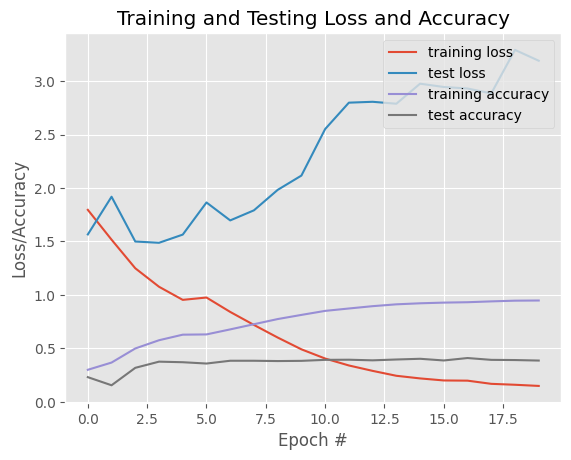

In [39]:
plot_history(history, 'performance_plots/effb0.png')

#### B1 

In [18]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (240,240) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 240, 240, 3)


2023-08-30 11:28:36.918105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-30 11:28:36.918301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-30 11:28:36.986033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipe

In [19]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB1
batch_size = 32
img_height = 240
img_width = 240


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB1(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b1 = tf.keras.Model(inputs,outputs) 
eff_b1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b1.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b1.save('model_weights/effnet_b1.h5')

Epoch 1/20


2023-08-30 11:28:38.429289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-30 11:28:38.429473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-30 11:28:45.989242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-30 11:28:48.996312: I

840/840 [==============================] - ETA: 0s - loss: 1.8853 - accuracy: 0.2927

2023-08-30 11:30:59.025586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-30 11:30:59.025955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


840/840 [==============================] - 149s 134ms/step - loss: 1.8853 - accuracy: 0.2927 - val_loss: 1.5905 - val_accuracy: 0.1822
Epoch 2/20
840/840 [==============================] - 109s 130ms/step - loss: 1.4738 - accuracy: 0.3674 - val_loss: 1.5017 - val_accuracy: 0.2777
Epoch 3/20
840/840 [==============================] - 109s 130ms/step - loss: 1.2991 - accuracy: 0.4711 - val_loss: 1.5625 - val_accuracy: 0.3132
Epoch 4/20
840/840 [==============================] - 113s 134ms/step - loss: 1.1177 - accuracy: 0.5551 - val_loss: 1.4341 - val_accuracy: 0.3714
Epoch 5/20
840/840 [==============================] - 111s 132ms/step - loss: 0.9927 - accuracy: 0.6054 - val_loss: 1.5160 - val_accuracy: 0.3447
Epoch 6/20
840/840 [==============================] - 112s 133ms/step - loss: 0.8986 - accuracy: 0.6470 - val_loss: 1.6710 - val_accuracy: 0.3902
Epoch 7/20
840/840 [==============================] - 114s 136ms/step - loss: 0.8167 - accuracy: 0.6822 - val_loss: 1.6893 - val_accura

In [38]:
tf.saved_model.save(eff_b1, 'model_weights/effnet_b1')

2023-08-29 15:28:13.244324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-29 15:28:13.274321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-08-29 15:28:13.296737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,120,120,16]
	 [[{{node inputs}}]]
2023-08-29 

INFO:tensorflow:Assets written to: model_weights/effnet_b1/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b1/assets


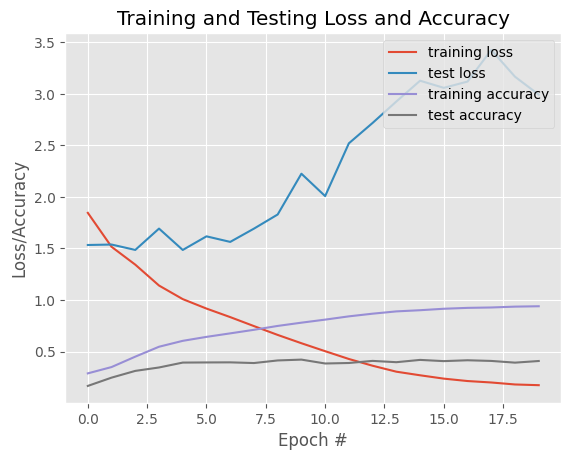

In [39]:
plot_history(history, 'performance_plots/effb1.png')

#### B2

In [44]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (260,260) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 260, 260, 3)


2023-08-29 10:58:49.691619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-29 10:58:49.692123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]


In [45]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB2
batch_size = 32
img_height = 260
img_width = 260

inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB2(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b2 = tf.keras.Model(inputs,outputs) 
eff_b2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b2.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b2.save('model_weights/effnet_b2.h5')

Epoch 1/20


2023-08-29 10:58:52.360438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-29 10:58:52.360862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 10:59:09.866328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.3010

2023-08-29 11:01:51.910125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-29 11:01:51.910320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]


840/840 [==============================] - 190s 168ms/step - loss: 1.8224 - accuracy: 0.3010 - val_loss: 1.5293 - val_accuracy: 0.2420
Epoch 2/20
840/840 [==============================] - 139s 165ms/step - loss: 1.4706 - accuracy: 0.3812 - val_loss: 1.5691 - val_accuracy: 0.2636
Epoch 3/20
840/840 [==============================] - 140s 167ms/step - loss: 1.2586 - accuracy: 0.4942 - val_loss: 1.5034 - val_accuracy: 0.3122
Epoch 4/20
840/840 [==============================] - 140s 167ms/step - loss: 1.1389 - accuracy: 0.5528 - val_loss: 1.5330 - val_accuracy: 0.3362
Epoch 5/20
840/840 [==============================] - 141s 167ms/step - loss: 1.0105 - accuracy: 0.6025 - val_loss: 1.5168 - val_accuracy: 0.3734
Epoch 6/20
840/840 [==============================] - 140s 167ms/step - loss: 0.9437 - accuracy: 0.6326 - val_loss: 1.5306 - val_accuracy: 0.3842
Epoch 7/20
840/840 [==============================] - 140s 167ms/step - loss: 0.8474 - accuracy: 0.6711 - val_loss: 1.7446 - val_accura

In [46]:
tf.saved_model.save(eff_b2, 'model_weights/effnet_b2')

2023-08-29 11:46:31.778605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-29 11:46:31.808610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-08-29 11:46:31.830709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,130,130,16]
	 [[{{node inputs}}]]
2023-08-29 

INFO:tensorflow:Assets written to: model_weights/effnet_b2/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b2/assets


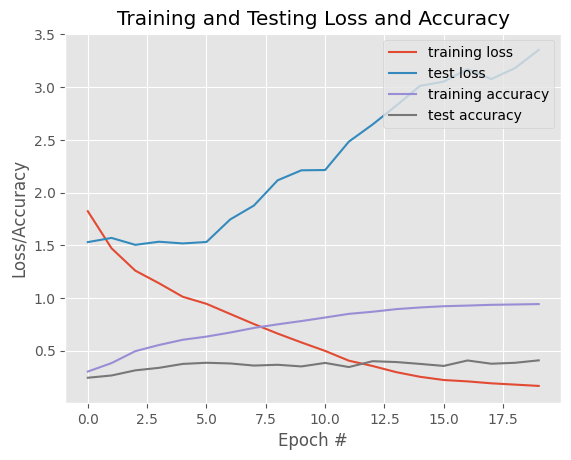

In [47]:
plot_history(history, 'performance_plots/effb2.png')

#### B3

In [48]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [49]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (300,300) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 300, 300, 3)


2023-08-29 11:47:27.134986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-29 11:47:27.135492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


In [50]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB3
batch_size = 32
img_height = 300
img_width = 300


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB3(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b3 = tf.keras.Model(inputs,outputs) 
eff_b3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b3.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b3.save('model_weights/effnet_b3.h5')

Epoch 1/20


2023-08-29 11:47:28.721248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 11:47:28.721438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 11:47:38.426087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - ETA: 0s - loss: 1.8615 - accuracy: 0.2954

2023-08-29 11:51:38.860234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-29 11:51:38.860633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


840/840 [==============================] - 266s 269ms/step - loss: 1.8615 - accuracy: 0.2954 - val_loss: 1.5331 - val_accuracy: 0.2119
Epoch 2/20
840/840 [==============================] - 224s 267ms/step - loss: 1.4693 - accuracy: 0.3847 - val_loss: 1.5437 - val_accuracy: 0.2771
Epoch 3/20
840/840 [==============================] - 224s 267ms/step - loss: 1.2469 - accuracy: 0.5051 - val_loss: 1.4322 - val_accuracy: 0.3515
Epoch 4/20
840/840 [==============================] - 224s 266ms/step - loss: 1.1322 - accuracy: 0.5626 - val_loss: 1.7019 - val_accuracy: 0.3569
Epoch 5/20
840/840 [==============================] - 224s 266ms/step - loss: 0.9826 - accuracy: 0.6171 - val_loss: 1.5000 - val_accuracy: 0.3668
Epoch 6/20
840/840 [==============================] - 223s 266ms/step - loss: 0.8991 - accuracy: 0.6515 - val_loss: 1.6242 - val_accuracy: 0.4058
Epoch 7/20
840/840 [==============================] - 225s 268ms/step - loss: 0.8141 - accuracy: 0.6865 - val_loss: 1.5379 - val_accura

In [51]:
tf.saved_model.save(eff_b3, 'model_weights/effnet_b3')

2023-08-29 13:03:19.268555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,40]
	 [[{{node inputs}}]]
2023-08-29 13:03:19.284722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-08-29 13:03:19.295977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,150,24]
	 [[{{node inputs}}]]
2023-08-29 

INFO:tensorflow:Assets written to: model_weights/effnet_b3/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b3/assets


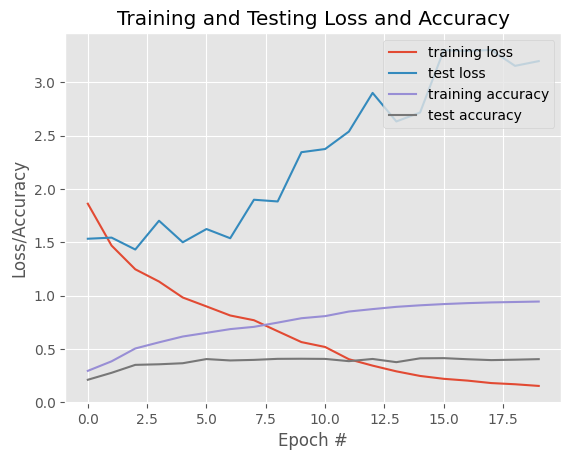

In [52]:
plot_history(history, 'performance_plots/effb3.png')

#### B4

In [18]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (380,380) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 380, 380, 3)


2023-08-29 13:49:38.321436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:49:38.321631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:49:38.384820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

In [22]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB4
batch_size = 32
img_height = 380
img_width = 380


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB4(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b4 = tf.keras.Model(inputs,outputs) 
eff_b4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b4.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b4.save('model_weights/effnet_b4.h5')

2023-08-29 13:55:28.648722: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/20


2023-08-29 13:55:40.617848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-29 13:55:52.605170: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 28.69MiB (rounded to 30081024)requested by op model_2/efficientnetb4/block6g_expand_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-29 13:55:52.605436: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-08-29 13:55:52.605468: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 557, Chunks in use: 538. 139.2KiB allocated for chunks. 1

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/efficientnetb4/block6g_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/Python/Python-3.10.1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/Python/Python-3.10.1/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5733/3280013457.py", line 15, in <module>
      history = eff_b4.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_2/efficientnetb4/block6g_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,1632,12,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/efficientnetb4/block6g_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_133835]

In [ ]:
tf.saved_model.save(eff_b4, 'model_weights/effnet_b4')plot_history(history, 'performance_plots/effb0.png')

In [ ]:
plot_history(history, 'performance_plots/effb4.png')

#### B5

In [20]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (456,456) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 456, 456, 3)


2023-08-29 13:30:14.390612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-29 13:30:14.390812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:30:14.580152: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipe

In [21]:
#efficient net b5 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB5
batch_size = 32
img_height = 456
img_width = 456


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB5(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b5 = tf.keras.Model(inputs,outputs) 
eff_b5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b5.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b5.save('model_weights/effnet_b5.h5')

Epoch 1/20


2023-08-29 13:30:19.019056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:30:19.019443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-29 13:30:49.087905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-29 13:31:03.841377: 

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/efficientnetb5/block2d_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/Python/Python-3.10.1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/Python/Python-3.10.1/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/opt/Python/Python-3.10.1/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4352/3503616654.py", line 15, in <module>
      history = eff_b5.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/cs/student/msc/aisd/2022/yintimun/.local/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/efficientnetb5/block2d_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,240,114,114] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/efficientnetb5/block2d_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_134676]

In [ ]:
tf.saved_model.save(eff_b5, 'model_weights/effnet_b5')

In [ ]:
plot_history(history, 'performance_plots/effb5.png')

#### B6

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (528,528) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

In [ ]:
#efficient net b6 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB6
batch_size = 32
img_height = 528
img_width = 528


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB6(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b6 = tf.keras.Model(inputs,outputs) 
eff_b6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b6.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b6.save('model_weights/effnet_b6.h5')

In [ ]:
tf.saved_model.save(eff_b6, 'model_weights/effnet_b6')

In [ ]:
plot_history(history, 'performance_plots/effb6.png')

#### B7

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (600,600) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

In [ ]:
#efficient net b7 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB7
batch_size = 32
img_height = 600
img_width = 600


inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB7(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_b7 = tf.keras.Model(inputs,outputs) 
eff_b7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = eff_b7.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20) 
eff_b7.save('model_weights/effnet_b7.h5')

In [ ]:
tf.saved_model.save(eff_b7, 'model_weights/effnet_b7')

In [ ]:
plot_history(history, 'performance_plots/effb7.png')

# Other baselines - VGGFACE16, RES, MOBILE 

In [23]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
target_size = (200,200)
img_height = 200
img_width = 200
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 

### VGG-16

In [25]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
base = VGG16(include_top=False, input_tensor=x, weights=None)

# Freeze the pretrained weights
base.trainable = False

# Build the custom top layers
x = base.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation = 'relu')(x) 
x = Dropout(0.5)(x) 
output = Dense(num_classes, activation = 'softmax')(x) 

# Create the final model
vgg_tl = Model(inputs, output)
vgg_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_saved = vgg_tl.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)


Epoch 1/20


2023-08-29 13:56:35.982300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:56:35.982497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26880]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:56:36.658340: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08

840/840 [==============================] - ETA: 0s - loss: 1.6849 - accuracy: 0.2509

2023-08-29 13:58:02.153665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-29 13:58:02.154048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


840/840 [==============================] - 233s 277ms/step - loss: 1.6849 - accuracy: 0.2509 - val_loss: 1.5123 - val_accuracy: 0.1730
Epoch 2/20
840/840 [==============================] - 42s 50ms/step - loss: 1.5963 - accuracy: 0.2948 - val_loss: 1.4946 - val_accuracy: 0.2133
Epoch 3/20
840/840 [==============================] - 41s 49ms/step - loss: 1.5786 - accuracy: 0.2987 - val_loss: 1.4929 - val_accuracy: 0.2111
Epoch 4/20
840/840 [==============================] - 42s 50ms/step - loss: 1.5757 - accuracy: 0.2987 - val_loss: 1.4878 - val_accuracy: 0.2161
Epoch 5/20
840/840 [==============================] - 42s 50ms/step - loss: 1.5719 - accuracy: 0.2999 - val_loss: 1.4995 - val_accuracy: 0.1783
Epoch 6/20
840/840 [==============================] - 41s 49ms/step - loss: 1.5692 - accuracy: 0.3068 - val_loss: 1.4900 - val_accuracy: 0.1959
Epoch 7/20
840/840 [==============================] - 42s 50ms/step - loss: 1.5685 - accuracy: 0.3060 - val_loss: 1.4787 - val_accuracy: 0.2396
E

In [26]:
test_loss, test_accuracy = vgg_tl.evaluate(testing_ds_resized)
print("Test accuracy:", test_accuracy)

225/225 [==============================] - 9s 39ms/step - loss: 1.4917 - accuracy: 0.2063
Test accuracy: 0.20632487535476685


In [ ]:
# ###to be do 


# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping

# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Create and compile your model
# model = ...  # Define your model here
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model with the EarlyStopping callback
# history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=32, epochs=100, callbacks=[early_stopping])

# # Access training history
# print(history.history)


In [27]:
vgg_tl.save('model_weights/vgg.h5')

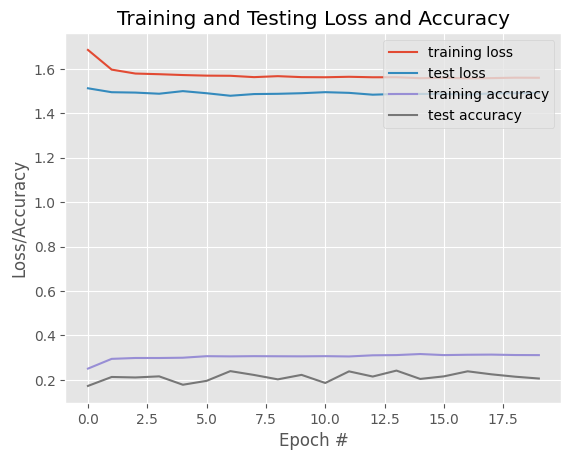

In [28]:
plot_history(model_saved, 'performance_plots/vgg.png')

### Mobile Net

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load and preprocess the data
# (Assuming you've already defined training_ds_resized and testing_ds_resized)

# Define the MobileNetV2 base model
base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights=None)

# Optionally freeze the weights of the base model
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)

output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=32, epochs=20)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_ds_resized)

# Print test accuracy
print("Test Accuracy:", test_accuracy)


Epoch 1/20
840/840 [==============================] - 24s 26ms/step - loss: 1.8428 - accuracy: 0.1643 - val_loss: 1.5814 - val_accuracy: 0.2471
Epoch 2/20
840/840 [==============================] - 21s 25ms/step - loss: 1.7919 - accuracy: 0.1631 - val_loss: 1.5811 - val_accuracy: 0.2471
Epoch 3/20
840/840 [==============================] - 21s 25ms/step - loss: 1.7919 - accuracy: 0.1619 - val_loss: 1.5810 - val_accuracy: 0.2471
Epoch 4/20
840/840 [==============================] - 21s 25ms/step - loss: 1.7919 - accuracy: 0.1627 - val_loss: 1.5810 - val_accuracy: 0.2471
Epoch 5/20
840/840 [==============================] - 22s 26ms/step - loss: 1.7919 - accuracy: 0.1629 - val_loss: 1.5811 - val_accuracy: 0.2471
Epoch 6/20
840/840 [==============================] - 20s 24ms/step - loss: 1.7919 - accuracy: 0.1640 - val_loss: 1.5811 - val_accuracy: 0.2471
Epoch 7/20
840/840 [==============================] - 21s 25ms/step - loss: 1.7919 - accuracy: 0.1646 - val_loss: 1.5811 - val_accuracy:

In [30]:
model.save('model_weights/mob.h5')

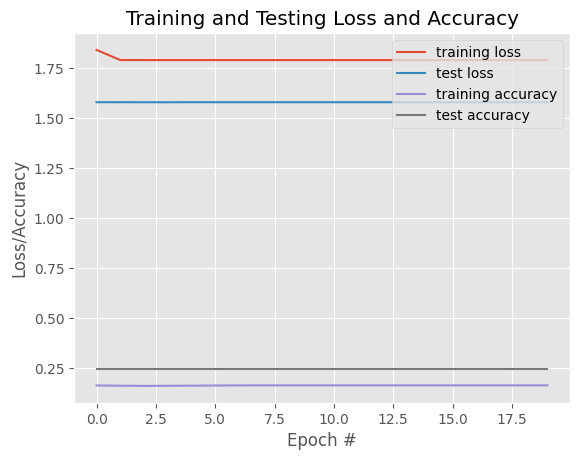

In [31]:
plot_history(history, 'performance_plots/mob.png')

### Custom CNN

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

import tensorflow as tf 

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200,200,3)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(6, activation='softmax'))

# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    training_ds,
    epochs=20,
    validation_data=testing_ds,
    callbacks=[checkpoint_callback]
)

In [ ]:
model.save('model_weights/custom.h5')

In [ ]:
plot_history(history, 'performance_plots/custom.png')

### ResNet

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define image dimensions and batch size
img_height = 240
img_width = 240
batch_size = 32

# Create a baseline ResNet model
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Add custom top layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_ds_resized)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
840/840 [==============================] - 110s 97ms/step - loss: 1.5795 - accuracy: 0.3328 - val_loss: 1.5425 - val_accuracy: 0.2538
Epoch 2/20
840/840 [==============================] - 79s 95ms/step - loss: 1.4437 - accuracy: 0.3737 - val_loss: 1.8791 - val_accuracy: 0.1559
Epoch 3/20
840/840 [==============================] - 80s 95ms/step - loss: 1.3555 - accuracy: 0.4212 - val_loss: 1.5988 - val_accuracy: 0.2147
Epoch 4/20
840/840 [==============================] - 79s 95ms/step - loss: 1.2362 - accuracy: 0.4929 - val_loss: 1.5949 - val_accuracy: 0.2940
Epoch 5/20
840/840 [==============================] - 80s 95ms/step - loss: 1.1354 - accuracy: 0.5376 - val_loss: 2.6144 - val_accuracy: 0.1470
Epoch 6/20
840/840 [==============================] - 80s 96ms/step - loss: 1.0661 - accuracy: 0.5670 - val_loss: 4.3243 - val_accuracy: 0.0907
Epoch 7/20
840/840 [==============================] - 80s 96ms/step - loss: 0.9974 - accuracy: 0.6003 - val_loss: 1.5643 - val_accuracy

In [21]:
model.save('model_weights/res_tl.h5')

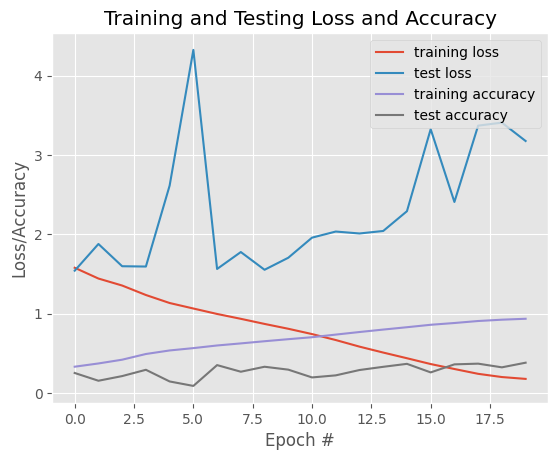

In [22]:
plot_history(history, 'performance_plots/res.png')

In [23]:
eff_b1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 240, 240, 3)]       0         
                                                                 
 efficientnetb1 (Functional)  (None, 6)                6582925   
                                                                 
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
_________________________________________________________________


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 25,692,038
Trainable params: 25,638,918
Non-trainable params: 53,120
_________________________________________________________________


In [32]:
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.models import Model
models = [eff_b1, model]

input = tf.keras.Input(shape=(240,240,3), name = 'input') 
outputs = [model(input) for model in models]

x= Concatenate()(outputs) 
x= Dropout(0.5)(x) 
output = Dense(6, activation = 'softmax', name = 'output')(x) 

con_model = Model(input,output,name = 'Concatenate_Model') 
con_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = con_model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)

Epoch 1/20


2023-08-30 12:47:18.972119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inConcatenate_Model/model/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - 237s 236ms/step - loss: 1.3543 - accuracy: 0.4628 - val_loss: 1.4829 - val_accuracy: 0.2887
Epoch 2/20
840/840 [==============================] - 196s 234ms/step - loss: 1.1524 - accuracy: 0.5427 - val_loss: 1.5136 - val_accuracy: 0.2211
Epoch 3/20
840/840 [==============================] - 195s 232ms/step - loss: 1.0463 - accuracy: 0.5832 - val_loss: 1.3820 - val_accuracy: 0.3957
Epoch 4/20
840/840 [==============================] - 198s 235ms/step - loss: 0.9686 - accuracy: 0.6077 - val_loss: 1.3416 - val_accuracy: 0.3915
Epoch 5/20
840/840 [==============================] - 195s 232ms/step - loss: 0.8933 - accuracy: 0.6471 - val_loss: 1.4041 - val_accuracy: 0.3887
Epoch 6/20
840/840 [==============================] - 194s 231ms/step - loss: 0.8341 - accuracy: 0.6842 - val_loss: 1.4271 - val_accuracy: 0.4029
Epoch 7/20
840/840 [==============================] - 194s 231ms/step - loss: 0.7730 - accuracy: 0.7182 - val_loss: 1.5972 - val_accura

In [34]:
con_model.save('model_weights/res-effb1.h5')

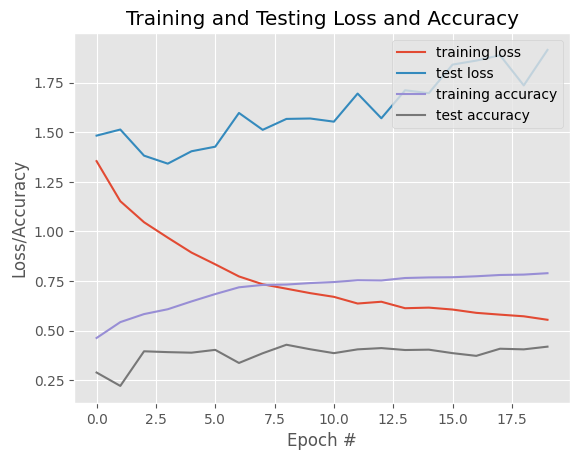

In [35]:
plot_history(history, 'performance_plots/res-effb1.png')

### Squeeze and Excitation

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model

# Define image dimensions and batch size
img_height = 240
img_width = 240
batch_size = 32
num_classes = 6  # Adjust based on the number of classes

# Create a baseline ResNet model
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Define the Squeeze and Excitation (SE) block
def se_block(inputs, ratio=16):
    channels = inputs.shape[-1]
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    scaled_inputs = Multiply()([inputs, se])
    return scaled_inputs

# Apply SE blocks to ResNet layers
outputs = []
for layer in base_model.layers:
    if 'conv' in layer.name:  # Apply SE block to convolutional layers
        se_output = se_block(layer.output)
        outputs.append(se_output)
    else:
        outputs.append(layer.output)

# Create a model with SE-augmented ResNet layers
se_resnet_model = Model(inputs=base_model.input, outputs=outputs)

# Add custom top layers
top_layers = GlobalAveragePooling2D()(se_resnet_model.layers[-1].output)
top_layers = Dense(1024, activation='relu')(top_layers)
top_layers = Dense(num_classes, activation='softmax')(top_layers)

# Create the final model
resse = Model(inputs=base_model.input, outputs=top_layers)

# Compile the model
resse.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = resse.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)

# Evaluate the model on test data
test_loss, test_accuracy = resse.evaluate(testing_ds_resized)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
840/840 [==============================] - 107s 103ms/step - loss: 1.5403 - accuracy: 0.3317 - val_loss: 1.5617 - val_accuracy: 0.2111
Epoch 2/20
840/840 [==============================] - 84s 100ms/step - loss: 1.4658 - accuracy: 0.3503 - val_loss: 1.7002 - val_accuracy: 0.1725
Epoch 3/20
840/840 [==============================] - 83s 99ms/step - loss: 1.3886 - accuracy: 0.3928 - val_loss: 1.9843 - val_accuracy: 0.1360
Epoch 4/20
840/840 [==============================] - 83s 99ms/step - loss: 1.2959 - accuracy: 0.4581 - val_loss: 1.9457 - val_accuracy: 0.1521
Epoch 5/20
840/840 [==============================] - 83s 99ms/step - loss: 1.1520 - accuracy: 0.5336 - val_loss: 1.7224 - val_accuracy: 0.2438
Epoch 6/20
840/840 [==============================] - 83s 99ms/step - loss: 1.0670 - accuracy: 0.5726 - val_loss: 1.8088 - val_accuracy: 0.2253
Epoch 7/20
840/840 [==============================] - 85s 101ms/step - loss: 1.0038 - accuracy: 0.5965 - val_loss: 1.8208 - val_accur

In [51]:
resse.save('model_weights/res-se.h5')

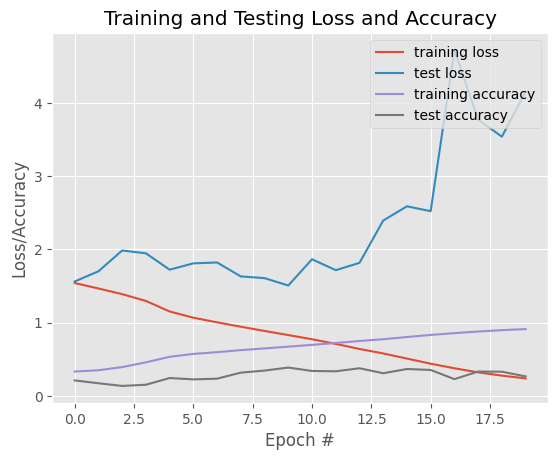

In [52]:
plot_history(history, 'performance_plots/res-se.png')

In [53]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers

# Define image dimensions and batch size
img_height = 240
img_width = 240
batch_size = 32
num_classes = 6  # Adjust based on the number of classes

# Create a baseline EfficientNetB1 model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Define the Squeeze and Excitation (SE) block
def se_block(inputs, ratio=16):
    channels = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    scaled_inputs = layers.Multiply()([inputs, se])
    return scaled_inputs

# Apply SE blocks to EfficientNetB1 layers
outputs = []
for layer in base_model.layers:
    if 'conv' in layer.name:  # Apply SE block to convolutional layers
        se_output = se_block(layer.output)
        outputs.append(se_output)
    else:
        outputs.append(layer.output)

# Create a model with SE-augmented EfficientNetB1 layers
se_eff_b1_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Add custom top layers
top_layers = layers.GlobalAveragePooling2D()(se_eff_b1_model.layers[-1].output)
top_layers = layers.Dense(1024, activation='relu')(top_layers)
top_layers = layers.Dense(num_classes, activation='softmax')(top_layers)

# Create the final model
eff_b1_with_se = tf.keras.Model(inputs=base_model.input, outputs=top_layers)

# Compile the model
eff_b1_with_se.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = eff_b1_with_se.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)



Epoch 1/20


2023-08-30 15:08:59.592795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - 139s 137ms/step - loss: 0.9841 - accuracy: 0.6178 - val_loss: 1.6576 - val_accuracy: 0.3433
Epoch 2/20
840/840 [==============================] - 113s 134ms/step - loss: 0.7611 - accuracy: 0.7039 - val_loss: 1.5369 - val_accuracy: 0.4065
Epoch 3/20
840/840 [==============================] - 113s 134ms/step - loss: 0.6481 - accuracy: 0.7495 - val_loss: 1.5654 - val_accuracy: 0.4108
Epoch 4/20
840/840 [==============================] - 111s 132ms/step - loss: 0.5623 - accuracy: 0.7822 - val_loss: 1.7382 - val_accuracy: 0.3957
Epoch 5/20
840/840 [==============================] - 111s 132ms/step - loss: 0.4869 - accuracy: 0.8127 - val_loss: 1.9655 - val_accuracy: 0.4170
Epoch 6/20
840/840 [==============================] - 111s 132ms/step - loss: 0.4077 - accuracy: 0.8442 - val_loss: 2.2751 - val_accuracy: 0.4291
Epoch 7/20
840/840 [==============================] - 112s 133ms/step - loss: 0.3436 - accuracy: 0.8708 - val_loss: 2.5141 - val_accura

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [55]:
eff_b1_with_se.save_weights('model_weights/effnet_b1_with_se.h5')

In [48]:
eff_b1.layers[-1].output

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'predictions')>

In [39]:
eff_b1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 240, 240, 3)]       0         
                                                                 
 efficientnetb1 (Functional)  (None, 6)                6582925   
                                                                 
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
_________________________________________________________________


In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 240, 240, 3)]       0         
                                                                 
 efficientnetb1 (Functional)  (None, 6)                6582925   
                                                                 
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
_________________________________________________________________


In [56]:
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.models import Model
models = [eff_b1_with_se, model]

input = tf.keras.Input(shape=(240,240,3), name = 'input') 
outputs = [model(input) for model in models]

x= Concatenate()(outputs) 
x= Dropout(0.5)(x) 
output = Dense(6, activation = 'softmax', name = 'output')(x) 

con_model = Model(input,output,name = 'Concatenate_Model') 
con_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = con_model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20)

Epoch 1/20


2023-08-30 17:01:14.179614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inConcatenate_Model/model/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


840/840 [==============================] - 265s 258ms/step - loss: 1.4277 - accuracy: 0.4173 - val_loss: 1.4114 - val_accuracy: 0.3891
Epoch 2/20
840/840 [==============================] - 212s 252ms/step - loss: 1.1440 - accuracy: 0.5319 - val_loss: 1.3685 - val_accuracy: 0.4195
Epoch 3/20
840/840 [==============================] - 213s 253ms/step - loss: 0.9832 - accuracy: 0.6232 - val_loss: 1.3634 - val_accuracy: 0.4270
Epoch 4/20
840/840 [==============================] - 211s 251ms/step - loss: 0.8693 - accuracy: 0.6689 - val_loss: 1.3667 - val_accuracy: 0.4335
Epoch 5/20
840/840 [==============================] - 211s 252ms/step - loss: 0.8053 - accuracy: 0.7035 - val_loss: 1.4337 - val_accuracy: 0.4172
Epoch 6/20
840/840 [==============================] - 211s 251ms/step - loss: 0.7534 - accuracy: 0.7120 - val_loss: 1.4401 - val_accuracy: 0.4369
Epoch 7/20
840/840 [==============================] - 210s 250ms/step - loss: 0.7144 - accuracy: 0.7206 - val_loss: 1.4862 - val_accura

In [59]:
con_model.save_weights('model_weights/res-effb1_se.h5')

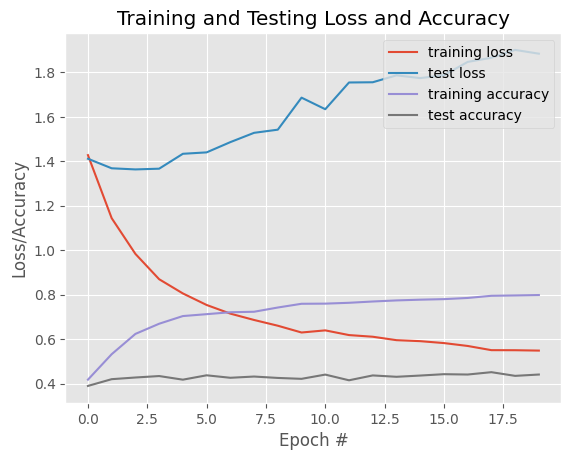

In [60]:
plot_history(history, 'performance_plots/res-effb1_se.png')